In [9]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

import tensorflow as tf
import keras

In [10]:
df = pd.read_csv('./data/train.csv')

In [159]:
def parse_sentence(sentence):
    ret = []
    nouns = []
    etc = []
    condition = False
    
    if sentence[:4] == '(광고)':
        etc.append(1)
        sentence = sentence[4:]
    else:
        etc.append(0)
    
    prev_pos = ''
    for word in mecab.pos(sentence):
        # 계시다면 등에서 다면이 N으로 파싱됨
        if word[1][:1] == 'N':
            if word[0][:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
            elif word[0] == '시' and prev_pos[:1] == 'N':  # 넣으나 마나.. 왜 그렇지?
                condition = True
            else:
                nouns.append(word[0])
        # 도 : 여도, 라도
        # 면 : 라면, 면
        elif word[1] == 'EC' and (word[0][-1:] in ('면', '도') or word[0][-2:] in ('도록')):
            condition = True
        elif word[1][-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            # nouns가 꼭 명사를 뜻하는 게 아니고 특색있는 키워드 모두를 포함
            nouns.append(word[0])
            ret.append([word[0], condition, nouns])
            nouns = []
            condition = False
        prev_pos = word[1]
    if len(nouns) > 0:
        nouns.append(word[0])
        ret.append([word[0], condition, nouns])
    
    # 가장 많은 단어를 가진 조건절만 남기고 나머지는 일반문장으로 원복
    max_len, selected = 0, -1
    for idx, item in enumerate(ret):
        if item[1] == True and len(item[2]) > max_len:
            selected, max_len = idx, len(item[2])
        ret[idx][1] = False
    if selected >= 0:
        ret[selected][1] = True
    return ret, etc

In [161]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited, etc = parse_sentence(item.text)
    # 일반 피쳐를 여기에서 etc에 넣는다
    etc.append(len(item.text))
    splited.append(etc)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2019-12-23 23:01:34.201649 0
2019-12-23 23:02:21.540476 100000
2019-12-23 23:03:11.293457 200000


In [162]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [163]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')

for normal in normals:
    for item in normal[:-2]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-2]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [164]:
cond_test = pd.Series(wc.get_counts('conditioned'))
cond_test[cond_test.index.map(len) > 1].head(5)

첫날       37
누군가     179
행복     6411
문자     8040
어요      193
dtype: int64

In [165]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]
general_df = general_df[general_df.index.map(len) > 1]

# 출현빈도가 일정 개수 이상되는 키워드만 표시해보면
display(conditioned_df[conditioned_df > 50])  # 조건절이 있는 문장에서 출현 빈도
display(general_df[general_df > 500])

누군가     179
행복     6411
문자     8040
어요      193
라운지     505
       ... 
트론       90
자채       90
자절      161
채팅       94
원거       64
Length: 1562, dtype: int64

행성        674
팀장      36208
입니다    105531
행복     103050
주말      50376
        ...  
지급금       803
전폭        560
도최       1488
사대       1196
승인서       660
Length: 1196, dtype: int64

In [166]:
# size of feature vector : 아래 두 숫자를 합한 것만큼이 피쳐개수가 됨 \ 위의 출현개수 기반으로 판단해볼것
# 참고 : 400/400 에서 늘려서.. 700/500 800/400 600/600 이렇게 해봐도.. 아래 케이스에서 못맞히는 개수가 12~14개 꾸준함... ㅎㅎ
# 400/400 일 때는 15개 틀림.. 좀 늘리면 12개 까지는 좋아질 수 있음.. 합이 1200을 넘으면 너무 느려져서 사용불가 (이 mac기준)
CONDITION_WORD_FTR_SIZE = 250  
GENERAL_WORD_FTR_SIZE = 450

conditioned_dic = list(conditioned_df.sort_values(ascending=False).head(CONDITION_WORD_FTR_SIZE).index)
general_dic = list(general_df.sort_values(ascending=False).head(GENERAL_WORD_FTR_SIZE).index)

In [167]:
train_conditioned = []
train_general = []
train_etc = []

In [168]:
original_idx = []
for normal in normals:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in normal[:-2]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    train_etc.append(normal[-2])
    original_idx.append(normal[-1])

In [169]:
for smishing in smishings:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in smishing[:-2]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    train_etc.append(smishing[-2])
    original_idx.append(smishing[-1])

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_conditioned = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer_general = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

tidf_conditioned = vectorizer_conditioned.fit_transform(train_conditioned)
tidf_general = vectorizer_general.fit_transform(train_general)

In [171]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned.toarray())
tidf_general = np.array(tidf_general.toarray())
ftr_etc = np.array(train_etc)
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < 0.6]
tidf_cond_valid = tidf_conditioned[(split >= 0.6) & (split < 0.8)]
tidf_cond_test = tidf_conditioned[split >= 0.8]

tidf_gen_train = tidf_general[split < 0.6]
tidf_gen_valid = tidf_general[(split >= 0.6) & (split < 0.8)]
tidf_gen_test = tidf_general[split >= 0.8]

ftr_etc_train = ftr_etc[split < 0.6]
ftr_etc_valid = ftr_etc[(split >= 0.6) & (split < 0.8)]
ftr_etc_test = ftr_etc[split >= 0.8]

tidf_label_train = tidf_label[split < 0.6]
tidf_label_valid = tidf_label[(split >= 0.6) & (split < 0.8)]
tidf_label_test = tidf_label[split >= 0.8]

tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((177533, 250), (59281, 250))

In [172]:
tidf_gen_train.shape, tidf_gen_valid.shape #, tidf_gen_test.shape

((177533, 450), (59281, 450))

In [173]:
n_cond, n_gen = CONDITION_WORD_FTR_SIZE, GENERAL_WORD_FTR_SIZE
n_etc = ftr_etc.shape[1]
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')
etc_input = keras.layers.Input(shape=(n_etc,), name='Etc')

#cond_vec_mlp = keras.layers.Embedding(n_cond, num_predictive_factors, )(cond_input)
#cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
#cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

#gen_vec_mlp = keras.layers.Embedding(n_gen, num_predictive_factors)(gen_input)
#gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
#gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

enc_input1 = keras.layers.Dense(16, name='AutoEncoder-1')(cond_input)
dropout_input1 = keras.layers.Dropout(0.2, name='enc_input1')(enc_input1)
enc_input2 = keras.layers.Dense(16, name='AutoEncoder-2')(gen_input)
dropout_input2 = keras.layers.Dropout(0.2, name='enc_input2')(enc_input2)

concat_mlp = keras.layers.merge.concatenate([dropout_input1, dropout_input2, etc_input])
#concat_dropout_mlp = keras.layers.Dropout(0.2)(concat_mlp)

dense = keras.layers.Dense(32, name='FullyConnected-1')(concat_mlp)
dropout_1 = keras.layers.Dropout(0.4, name='Dropout-1')(dense)

# dense_2 = keras.layers.Dense(128, name='FullyConnected-2')(dropout_1)
# dropout_2 = keras.layers.Dropout(0.3, name='Dropout-2')(dense_2)

# dense_3 = keras.layers.Dense(512, name='FullyConnected-3')(dropout_2)
# dropout_3 = keras.layers.Dropout(0.2, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.0025), name='FullyConnected-4', activation='relu')(dropout_1)

pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input, etc_input], output=pred_mlp)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])

/home/xikizima/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [174]:
tidf_label_valid.shape, sum(tidf_label_valid)

((59281,), 3724)

In [175]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, ftr_etc_train, tidf_label_train, normal_size=160, smishing_size=160):
        self.tidf_cond_train_normal = tidf_cond_train[tidf_label_train == 0]
        self.tidf_gen_train_normal = tidf_gen_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = tidf_cond_train[tidf_label_train == 1]
        self.tidf_gen_train_smishing = tidf_gen_train[tidf_label_train == 1]
        self.ftr_etc_train_normal = ftr_etc_train[tidf_label_train == 0]
        self.ftr_etc_train_smishing = ftr_etc_train[tidf_label_train == 1]
        self.normal_sample_size = normal_size
        self.smishing_sample_size = smishing_size
        self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) / (self.normal_sample_size + self.smishing_sample_size)))
        print('num_batch:', self.num_batch)
    
    def __len__(self):
        return self.num_batch
    
    def __getitem__(self, index):
        # random sampling. ignore index
        normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        normal_etc_sample = self.ftr_etc_train_normal[normal_sampling]
        smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        smishing_etc_sample = self.ftr_etc_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_etc_train = np.concatenate([normal_etc_sample, smishing_etc_sample])
        sample_label_train = [1 if x >= self.normal_sample_size else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train, sample_etc_train], sample_label_train

    def on_epoch_end(self):
        pass

In [184]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, ftr_etc_train, tidf_label_train, 320, 160)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, ftr_etc_valid, tidf_label_valid, 16000, 1000)

history = model.fit_generator(generator=train_gen,
                             epochs = 250,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch: 347
num_batch: 4
Epoch 1/100
347/347 [==============================] - 5s 14ms/step - loss: 4.7933e-04 - binary_crossentropy: 3.3397e-04 - acc: 1.0000 - val_loss: 9.4979e-04 - val_binary_crossentropy: 8.0613e-04 - val_acc: 0.9999
Epoch 2/100
347/347 [==============================] - 3s 8ms/step - loss: 5.9750e-04 - binary_crossentropy: 4.5327e-04 - acc: 1.0000 - val_loss: 0.0015 - val_binary_crossentropy: 0.0013 - val_acc: 0.9998
Epoch 3/100
347/347 [==============================] - 3s 7ms/step - loss: 5.2523e-04 - binary_crossentropy: 3.8422e-04 - acc: 0.9999 - val_loss: 0.0015 - val_binary_crossentropy: 0.0014 - val_acc: 0.9999
Epoch 4/100
347/347 [==============================] - 3s 8ms/step - loss: 3.7987e-04 - binary_crossentropy: 2.3994e-04 - acc: 1.0000 - val_loss: 0.0024 - val_binary_crossentropy: 0.0022 - val_acc: 0.9997
Epoch 5/100
347/347 [==============================] - 3s 8ms/step - loss: 3.1280e-04 - binary_crossentropy: 1.8071e-04 - acc: 1.0000 - val_los

347/347 [==============================] - 2s 6ms/step - loss: 2.3376e-04 - binary_crossentropy: 1.5901e-04 - acc: 1.0000 - val_loss: 0.0018 - val_binary_crossentropy: 0.0018 - val_acc: 0.9998
Epoch 41/100
347/347 [==============================] - 2s 7ms/step - loss: 5.5278e-04 - binary_crossentropy: 4.8472e-04 - acc: 0.9999 - val_loss: 0.0017 - val_binary_crossentropy: 0.0016 - val_acc: 0.9998
Epoch 42/100
347/347 [==============================] - 2s 6ms/step - loss: 4.1321e-04 - binary_crossentropy: 3.4294e-04 - acc: 1.0000 - val_loss: 0.0018 - val_binary_crossentropy: 0.0017 - val_acc: 0.9998
Epoch 43/100
347/347 [==============================] - 2s 6ms/step - loss: 2.8334e-04 - binary_crossentropy: 2.1074e-04 - acc: 1.0000 - val_loss: 0.0016 - val_binary_crossentropy: 0.0015 - val_acc: 0.9998
Epoch 44/100
347/347 [==============================] - 2s 6ms/step - loss: 5.0158e-04 - binary_crossentropy: 4.3313e-04 - acc: 0.9999 - val_loss: 0.0025 - val_binary_crossentropy: 0.0024 -

Epoch 80/100
347/347 [==============================] - 2s 6ms/step - loss: 4.0843e-04 - binary_crossentropy: 3.5751e-04 - acc: 1.0000 - val_loss: 0.0012 - val_binary_crossentropy: 0.0012 - val_acc: 0.9998
Epoch 81/100
347/347 [==============================] - 2s 6ms/step - loss: 4.1446e-04 - binary_crossentropy: 3.6222e-04 - acc: 0.9999 - val_loss: 0.0016 - val_binary_crossentropy: 0.0015 - val_acc: 0.9998
Epoch 82/100
347/347 [==============================] - 2s 6ms/step - loss: 4.8539e-04 - binary_crossentropy: 4.3520e-04 - acc: 0.9999 - val_loss: 0.0017 - val_binary_crossentropy: 0.0016 - val_acc: 0.9998
Epoch 83/100
347/347 [==============================] - 2s 6ms/step - loss: 4.1194e-04 - binary_crossentropy: 3.6593e-04 - acc: 0.9999 - val_loss: 0.0017 - val_binary_crossentropy: 0.0017 - val_acc: 0.9997
Epoch 84/100
347/347 [==============================] - 2s 6ms/step - loss: 2.1969e-04 - binary_crossentropy: 1.6845e-04 - acc: 1.0000 - val_loss: 0.0021 - val_binary_crossentr

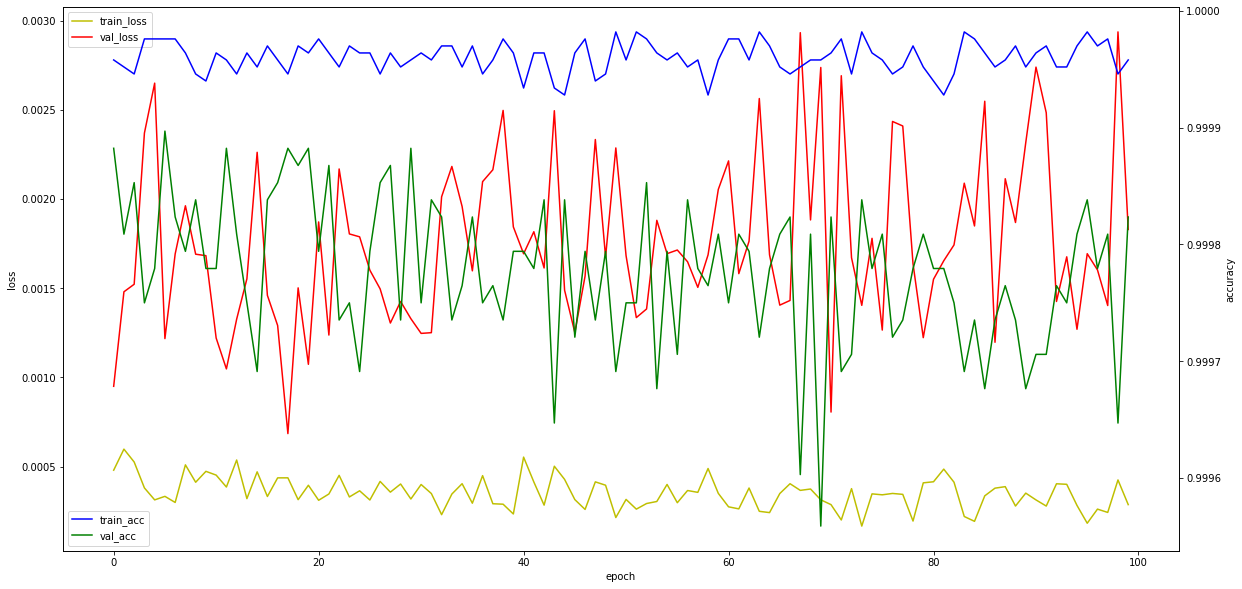

In [185]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

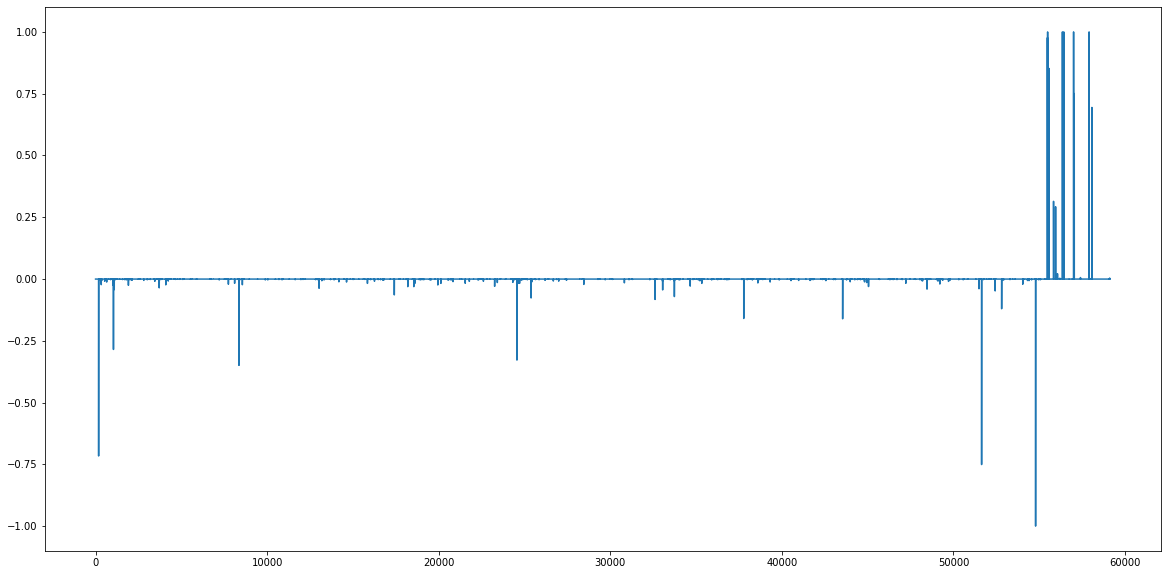

In [186]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test, ftr_etc_test], batch_size=320)
gap = tidf_label_test - pred_test.reshape([-1,])

plt.figure(figsize=(20,10))
plt.plot(gap)

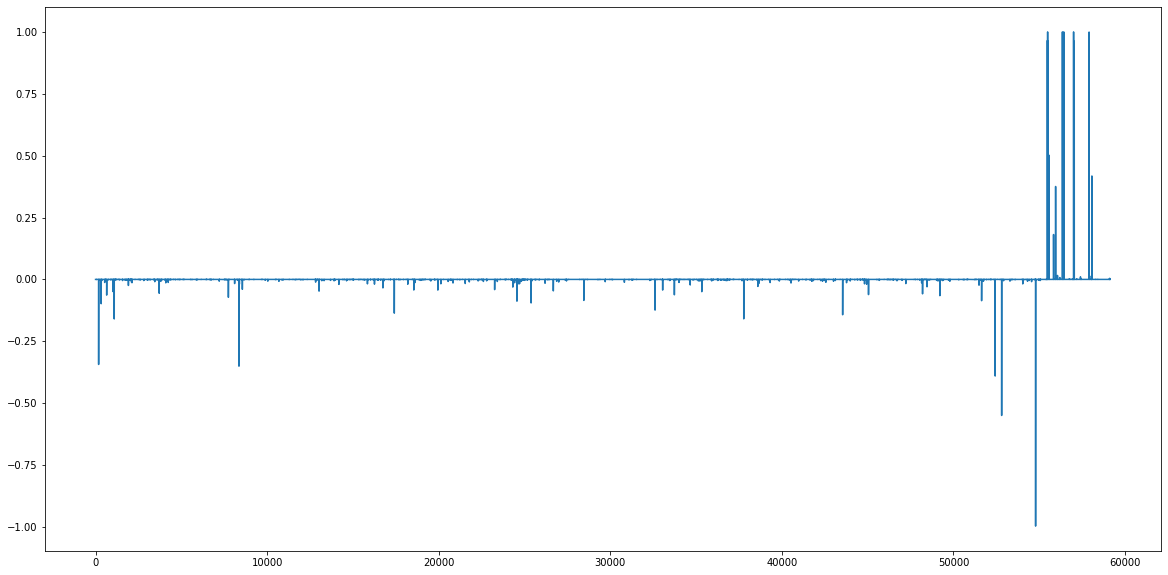

In [178]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test, ftr_etc_test], batch_size=320)
gap = tidf_label_test - pred_test.reshape([-1,])

plt.figure(figsize=(20,10))
plt.plot(gap)

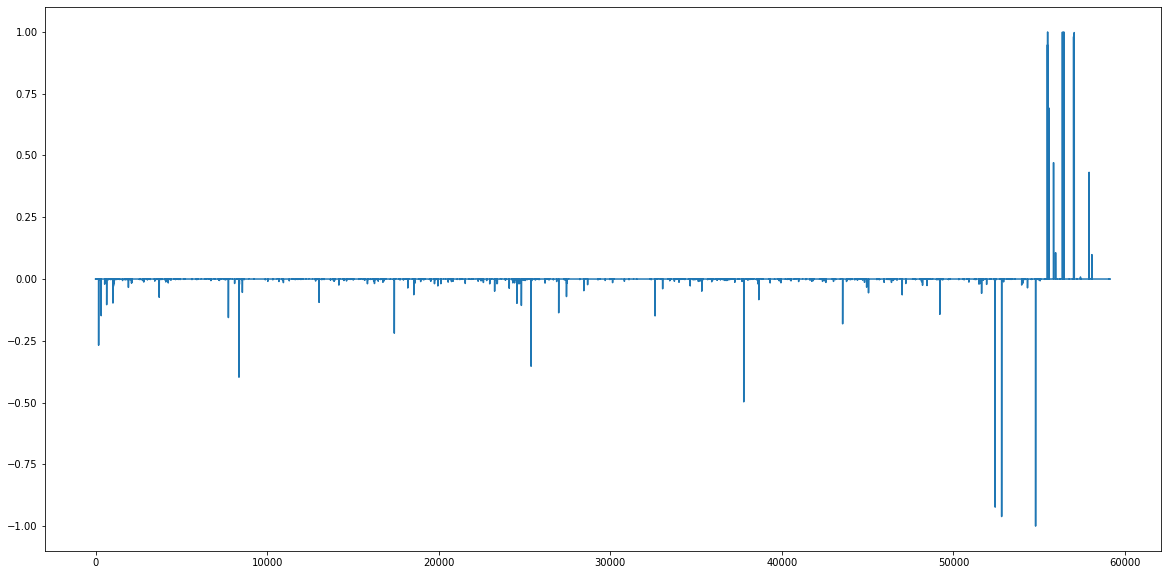

In [141]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test, ftr_etc_test], batch_size=320)
gap = tidf_label_test - pred_test.reshape([-1,])

plt.figure(figsize=(20,10))
plt.plot(gap)

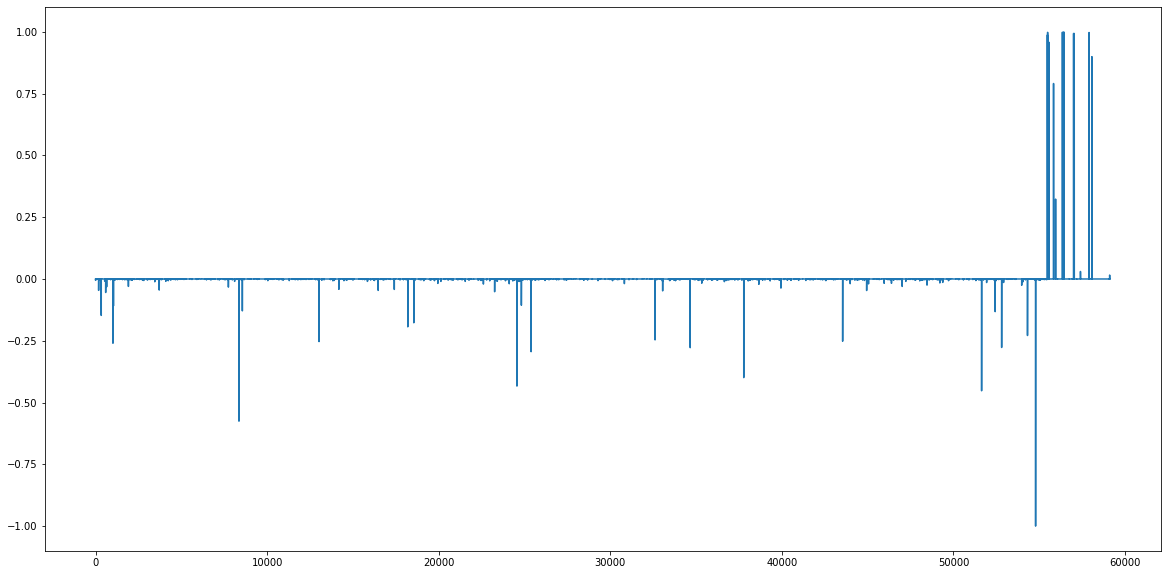

In [116]:
# 결과검증(overfit, underfit)
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test, ftr_etc_test], batch_size=320)
gap = tidf_label_test - pred_test.reshape([-1,])

plt.figure(figsize=(20,10))
plt.plot(gap)

auc : 0.9999245679793498


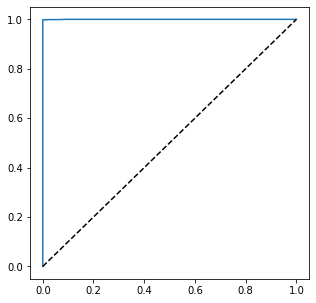

In [187]:
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(tidf_label_test, pred_test)
print('auc :', auc(fpr,tpr))

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,'-')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [188]:
df[df['id'].isin(np.array(original_idx)[split >= 0.8][gap > 0.5])].text.map(print)

(광고)XXX신년특별빠르게천만원월39000원통화1번(무료거부XXX-XXX-XXX)
(광고) 정관장에서 미리 설 준비하시고 특별한 혜택 받으세요!! 예약기간 : 13(화)  19(월) 행사내용 :- 밝을윤세트 은혜은세트 원앙세트 3종 구매 예약시 5% 포인트 추가 적립- 예약방법은 매장으로 문의하여 주세요. 20만원 XXX입 시 1만원 할인- 기간:11128까지적용카드: 현대이마트카드.삼성카드.XXX국민카드.현대카드.XXX카드 결재 시 적용됨. 예약문의 : 정관장 서울 이마트가양점 전화:XX-XXX-XXX 무료수신거부 : XXX-XXX-XXX(광고)정관장 사전예XXX
피플라이프재무설계XXX팀장입니다 이번에찾아뵙는 금융서비스라고해서은행 예.적금CMAMMF 등관련하여 1:1 재무설계를직접 찾아뵙고 무료상담을 도와드리고있습니다Ex) 현재-시중은행 1.25% 금리이용하시는분들같은 경우상담후-최저보증2.9% 비과세상품 이용하실수있는 방법을 기본베이스로안내를 도와드리고XXX고객님께서 가입되어있는 금융상품들을 다시한번 점검및진단을 함으로써개개인의 현금흐름표에 맞게(목돈마련결혼자금노후자금 등)맞춤형 포트폴리오 또한 안내를 드리고있습니다.평소 바쁘시다보니 전문가에게 이런 안내와 상담서비스를 받아보시지 못하셨을텐데 무료상담을 원하시면직접 집이나 회사앞까지 찾아뵙는 서비스이기XXX 시간절약도 하실수가 있습니다.현재 높은만족도와 많은혜택들을 받으시고 있기XXX 고객님께서도상담신청이라고 답장을 남겨주시면일정 확인차 전화를 드리겠습니다.감사합니다.제목없음
(광고)이마트 은평점 추석 선물세트 사전예약 특별혜택 마감일 917XXX입니다.예약접수:814(월)917XXX상품배송:915(금)929(금)(혜택1)11대 카드로 인기세트 구매시 최대 30%할인 및 구매 금액대별 최대 100만원 상품권 증정현대e삼성XXX국민XXX현대비씨XXX우리하나롯데XXX 이마트 카드로 구매시상품권 증정은 카드단체선물신세계포인트 신선N1 할인 이후의 실제 결제금액 기준(혜택2)신선 선물세트 신세계이마트 포인트 카드 

440       None
938       None
6221      None
137858    None
149795    None
195865    None
196896    None
252122    None
256306    None
Name: text, dtype: object

In [ ]:
# 제출 준비

In [189]:
submit_df = pd.read_csv('./data/public_test.csv')

In [190]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited, etc = parse_sentence(item.text)
    # 일반 피쳐를 여기에서 etc에 넣는다
    etc.append(len(item.text))
    splited.append(etc)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2019-12-23 23:22:07.671656 0


In [191]:
test_conditioned = []
test_general = []
test_etc = []

original_idx = []
for unknown in unknowns:
    conditioned = []
    general = []
    for item in unknown[:-2]:
        if item[1] == True:
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    test_conditioned.append(list(conditioned))
    test_general.append(list(general))
    test_etc.append(unknown[-2])
    original_idx.append(unknown[-1])

In [192]:
tidf_conditioned = vectorizer_conditioned.transform(test_conditioned).toarray()
tidf_general = vectorizer_general.transform(test_general).toarray()
ftr_etc = np.array(test_etc)

In [193]:
pred_y = model.predict(x=[tidf_conditioned, tidf_general, ftr_etc], verbose=1)

1626/1626 [==============================] - 0s 80us/step


In [195]:
pred_y[pred_y > 1.0] = 1.0

In [196]:
submit_df['smishing'] = np.abs(pred_y)

In [197]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20191223_2.csv', index=False)